In [1]:
import pandas as pd, numpy as np
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from glob import glob
from PIL import Image
from skimage import color
import cv2, matplotlib.pyplot as plt
import random
import gc
# Import essential libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import itertools
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import os
import cv2
from IPython.display import SVG
from sklearn.decomposition import PCA
import numpy as np
from numpy.random import rand
import cudf, cuml
from cuml.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from random import randrange
import time

In [2]:
features_ALL_IDB2_resnet = np.load('../input/pca-pretraining-featureextraction-resnet-all-idb2/ALL_IDB2_ExtractedFeatures.npy')
targets_ALL_IDB2 = np.load('../input/pca-pretraining-featureextraction-resnet-all-idb2/Targets.npy')

In [3]:
sc = StandardScaler()
features_ALL_IDB2_resnet = sc.fit_transform(features_ALL_IDB2_resnet)

In [4]:
targets_ALL_IDB2 = [np.argmax(y, axis=None, out=None) for y in targets_ALL_IDB2]
targets_ALL_IDB2 = np.asarray(targets_ALL_IDB2)

In [5]:
print("Features ALL-IDB2 ResNet: ", features_ALL_IDB2_resnet.shape)
print("Labels ALL-IDB2: ", targets_ALL_IDB2.shape)

Features ALL-IDB2 ResNet:  (2004, 2304)
Labels ALL-IDB2:  (2004,)


In [6]:
# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k  = opts['k']
    fold = opts['fold']
    xt = fold['xt']
    yt = fold['yt']
    xv = fold['xv']
    yv = fold['yv']
    
    # number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain = xt[:, x == 1]
    ytrain = yt.reshape(num_train)
    xvalid = xv[:, x == 1]
    yvalid = yv.reshape(num_valid)
    # Training
    mdl     = KNeighborsClassifier(n_neighbors= k)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc
    
    return error, acc
# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # parameters
    alpha = 0.99
    beta = 1 - alpha
    # original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost = 1
    else:
        # Get error rate
        error, acc = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost = alpha * error + beta * (num_feat / max_feat)
        
    return cost

In [7]:
# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # parameters
    alpha = 0.99
    beta = 1 - alpha
    # original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost = 1
    else:
        # Get error rate
        error, acc = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost = alpha * error + beta * (num_feat / max_feat)
        
    return cost

In [8]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X

In [9]:
def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin

In [10]:
def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x

In [11]:
def jfs(xtrain, ytrain, opts):
    # Parameters
    ub     = 1
    lb     = 0
    thres  = 0.5
    
    N          = opts['N']
    max_iter   = opts['T']
        
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position 
    X     = init_position(lb, ub, N, dim)
    
    # Binary conversion
    Xbin  = binary_conversion(X, thres, N, dim)
    
    # Fitness at first iteration
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    
    for i in range(N):
        fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
        if fit[i,0] < fitG:
            Xgb[0,:] = X[i,:]
            fitG     = fit[i,0]
    
    # Pre
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    curve[0,t] = fitG.copy()
    print("Generation:", t + 1)
    print("Best (JA):", curve[0,t])
    t += 1
    
    while t < max_iter:  
        Xnew  = np.zeros([N, dim], dtype='float') 
        
        # Identify best & worst in population
        idx_max = np.argmax(fit)
        Xw      = X[idx_max,np.newaxis,:].copy()
        idx_min = np.argmin(fit)
        Xb      = X[idx_min,np.newaxis,:].copy()       
          
        for i in range(N):
            for d in range(dim):
                # Random numbers
                r1 = rand();
                r2 = rand();
                # Position update (1)
                Xnew[i,d] = X[i,d] + r1 * (Xb[0,d] - abs(X[i,d])) - r2 * (Xw[0,d] - abs(X[i,d])) 
                # Boundary
                Xnew[i,d] = boundary(Xnew[i,d], lb[0,d], ub[0,d])
                
        # Binary conversion
        Xbin = binary_conversion(Xnew, thres, N, dim)
        
        # Greedy selection
        for i in range(N):
            Fnew = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if Fnew < fit[i,0]:
                X[i,:]   = Xnew[i,:]
                fit[i,0] = Fnew             
                
            if fit[i,0] < fitG:
                Xgb[0,:] = X[i,:]
                fitG     = fit[i,0]
             
        # Store result
        curve[0,t] = fitG.copy()
        print("Generation:", t + 1)
        print("Best (JA):", curve[0,t])
        t += 1            

            
    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    ja_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return ja_data

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(features_ALL_IDB2_resnet, targets_ALL_IDB2, test_size=0.3, shuffle=True)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

In [13]:
P    = 0.8       # switch probability
k     = 5     # k-value in KNN
N     = 20    # number of
T     = 100   # maximum number of iterations
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'P':P}

Generation: 1
Best (JA): 0.00481336805555556
Generation: 2
Best (JA): 0.004743923611111115
Generation: 3
Best (JA): 0.004743923611111115
Generation: 4
Best (JA): 0.004713541666666671
Generation: 5
Best (JA): 0.004691840277777782
Generation: 6
Best (JA): 0.004583333333333337
Generation: 7
Best (JA): 0.004583333333333337
Generation: 8
Best (JA): 0.004574652777777782
Generation: 9
Best (JA): 0.004574652777777782
Generation: 10
Best (JA): 0.004574652777777782
Generation: 11
Best (JA): 0.004552951388888893
Generation: 12
Best (JA): 0.004552951388888893
Generation: 13
Best (JA): 0.004544270833333337
Generation: 14
Best (JA): 0.004535590277777782
Generation: 15
Best (JA): 0.00450086805555556
Generation: 16
Best (JA): 0.0044184027777777815
Generation: 17
Best (JA): 0.0044184027777777815
Generation: 18
Best (JA): 0.0044184027777777815
Generation: 19
Best (JA): 0.0044184027777777815
Generation: 20
Best (JA): 0.0044184027777777815
Generation: 21
Best (JA): 0.0044184027777777815
Generation: 22
Bes

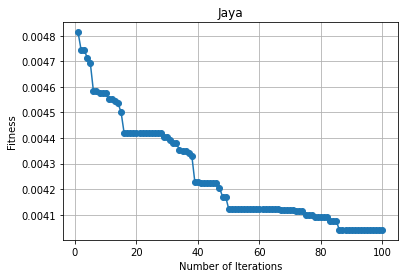

In [14]:
# perform feature selection
start_time = time.time()
fmdl  = jfs(features_ALL_IDB2_resnet, targets_ALL_IDB2, opts)
print("Run Time --- %s seconds ---" % (time.time() - start_time))

sf    = fmdl['sf']

# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

mdl       = KNeighborsClassifier(n_neighbors= k) 
mdl.fit(x_train, y_train)

# accuracy
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
print("Accuracy:", 100 * Acc)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('Jaya')
ax.grid()
plt.show()

In [15]:
np.save("SelectedFeaturesIndexs_ALL_IDB2_ResNet_100iter.npy", fmdl['sf'])